# 「放送・通信」を特徴量として抽出する！

In [1]:
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer
import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
train_df = pd.read_csv("../data/outer_data/train.csv")
test_df = pd.read_csv('../data/outer_data/test.csv')

In [3]:
train_df.head(2)

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間


### テキスト整形用関数群

In [4]:
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

「放送・通信」特徴量について準備

In [5]:
broadcast = train_df['放送・通信']

In [7]:
for i in range(len(broadcast)):
    try:
        broadcast.loc[i] = clean_text(broadcast.loc[i])
        broadcast.loc[i] = broadcast.loc[i].replace('／', '')
        broadcast.loc[i] = broadcast.loc[i].replace('\t', ' ')
    except:
        pass

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_1751/593145194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broadcast.loc[i] = clean_text(broadcast.loc[i])
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_1751/593145194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broadcast.loc[i] = broadcast.loc[i].replace('／', '')
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_1751/593145194.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [12]:
broadcast[50:80]

50                          インターネット対応 光ファイバー
51               インターネット対応 catv インターネット使用料無料
52                                 インターネット対応
53                     インターネット対応 光ファイバー catv
54    光ファイバー catv csアンテナ bsアンテナ インターネット使用料無料
55                 光ファイバー catv csアンテナ bsアンテナ
56       インターネット対応 光ファイバー catv csアンテナ bsアンテナ
57       高速インターネット 光ファイバー catv csアンテナ bsアンテナ
58                               catv bsアンテナ
59                 光ファイバー catv csアンテナ bsアンテナ
60              インターネット対応 catv csアンテナ bsアンテナ
61                                      catv
62                             csアンテナ bsアンテナ
63                                    光ファイバー
64                          インターネット対応 光ファイバー
65                          インターネット対応 bsアンテナ
66                                    光ファイバー
67    光ファイバー catv csアンテナ bsアンテナ インターネット使用料無料
68            インターネット対応 光ファイバー csアンテナ bsアンテナ
69                    インターネット対応 インターネット使用料無料
70                                 インターネット対応
71                     インターネット対応 光ファイバー catv
72        

In [13]:
from cmath import nan


broadcasts = []
for i in range(len(broadcast)):
    text = broadcast.loc[i]
    broadcast_list = []
    try:
        if 'インターネット対応' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)
        
        if 'catv' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if 'csアンテナ' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if 'bsアンテナ' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if '光ファイバー' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if '高速インターネット' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if 'インターネット使用料無料' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

    except:#「キッチン」特徴量に何も記載がない場合
        broadcast_list = [0 for k in range(7)] #ホントに0埋めで良いの？

    broadcasts.append( broadcast_list )

broadcasts = pd.DataFrame( broadcasts )

In [14]:
broadcasts.columns = ['インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー',
'高速インターネット','インターネット使用料無料']

In [15]:
broadcasts.to_csv('../data/handmade_data/broadcasts.csv',index=False)

テストデータにも同様の処理を行う

In [17]:
broadcast = test_df['放送・通信']

In [18]:
for i in range(len(broadcast)):
    try:
        broadcast.loc[i] = clean_text(broadcast.loc[i])
        broadcast.loc[i] = broadcast.loc[i].replace('／', '')
        broadcast.loc[i] = broadcast.loc[i].replace('\t', ' ')
    except:
        pass

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_1751/593145194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broadcast.loc[i] = clean_text(broadcast.loc[i])
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_1751/593145194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broadcast.loc[i] = broadcast.loc[i].replace('／', '')
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_1751/593145194.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [19]:
from cmath import nan


broadcasts = []
for i in range(len(broadcast)):
    text = broadcast.loc[i]
    broadcast_list = []
    try:
        if 'インターネット対応' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)
        
        if 'catv' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if 'csアンテナ' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if 'bsアンテナ' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if '光ファイバー' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if '高速インターネット' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

        if 'インターネット使用料無料' in text:
            broadcast_list.append(1)
        else:
            broadcast_list.append(0)

    except:#「キッチン」特徴量に何も記載がない場合
        broadcast_list = [0 for k in range(7)] #ホントに0埋めで良いの？

    broadcasts.append( broadcast_list )

broadcasts = pd.DataFrame( broadcasts )

In [20]:
broadcasts.columns = ['インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー',
'高速インターネット','インターネット使用料無料']

In [21]:
broadcasts.to_csv('../data/test_data/test_broadcasts.csv',index=False)

これをLightGBMに突っ込んでみる！

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, sepa_bath_toilets, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], 
                    buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    broadcasts], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent,test_sepa_bath_toilets, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                    test_broadcasts], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    'インターネット対応','catv','csアンテナ','bsアンテナ','光ファイバー',
                    '高速インターネット','インターネット使用料無料'
                    ]

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2714
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 27
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48833.9	valid_1's rmse: 50173.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'バス・トイレ別', '光ファイバー', '定期借家', '建物構造', '所在地', '最寄り駅', '高速インターネット']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will b

[20]	training's rmse: 34610	valid_1's rmse: 37907.2
[30]	training's rmse: 26130.4	valid_1's rmse: 30967.9
[40]	training's rmse: 21117.4	valid_1's rmse: 27122.8
[50]	training's rmse: 17905.4	valid_1's rmse: 24770.5
[60]	training's rmse: 16007.9	valid_1's rmse: 23403.2
[70]	training's rmse: 14625.8	valid_1's rmse: 22378
[80]	training's rmse: 13642.6	valid_1's rmse: 21697.2
[90]	training's rmse: 12833.5	valid_1's rmse: 21132.1
[100]	training's rmse: 12190.7	valid_1's rmse: 20688.8
[110]	training's rmse: 11653.2	valid_1's rmse: 20303.1
[120]	training's rmse: 11177	valid_1's rmse: 19959.3
[130]	training's rmse: 10803.4	valid_1's rmse: 19702.4
[140]	training's rmse: 10409	valid_1's rmse: 19435.9
[150]	training's rmse: 10091.1	valid_1's rmse: 19252.9
[160]	training's rmse: 9797.71	valid_1's rmse: 19033.4
[170]	training's rmse: 9522.24	valid_1's rmse: 18864
[180]	training's rmse: 9277.57	valid_1's rmse: 18675.9
[190]	training's rmse: 9061.1	valid_1's rmse: 18501.4
[200]	training's rmse: 8844.8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'バス・トイレ別', '光ファイバー', '定期借家', '建物構造', '所在地', '最寄り駅', '高速インターネット']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will b

[20]	training's rmse: 34957.7	valid_1's rmse: 35749.3
[30]	training's rmse: 26822.6	valid_1's rmse: 28171.7
[40]	training's rmse: 22017.3	valid_1's rmse: 23951.7
[50]	training's rmse: 19073.2	valid_1's rmse: 21285.5
[60]	training's rmse: 17247.2	valid_1's rmse: 19778.6
[70]	training's rmse: 15916.6	valid_1's rmse: 18878.1
[80]	training's rmse: 14898.9	valid_1's rmse: 18305.1
[90]	training's rmse: 14096.7	valid_1's rmse: 18000.4
[100]	training's rmse: 13464.9	valid_1's rmse: 17799.6
[110]	training's rmse: 12929.7	valid_1's rmse: 17588.9
[120]	training's rmse: 12449.9	valid_1's rmse: 17514.5
[130]	training's rmse: 12033.8	valid_1's rmse: 17471.7
[140]	training's rmse: 11629.5	valid_1's rmse: 17415.6
[150]	training's rmse: 11273.2	valid_1's rmse: 17410.1
[160]	training's rmse: 10950.5	valid_1's rmse: 17383.8
Early stopping, best iteration is:
[156]	training's rmse: 11084	valid_1's rmse: 17367.9
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'バス・トイレ別', '光ファイバー', '定期借家', '建物構造', '所在地', '最寄り駅', '高速インターネット']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will b

[20]	training's rmse: 35076.9	valid_1's rmse: 34778.4
[30]	training's rmse: 26907	valid_1's rmse: 27098.3
[40]	training's rmse: 22137.5	valid_1's rmse: 22957
[50]	training's rmse: 19130.1	valid_1's rmse: 20570.4
[60]	training's rmse: 17245.1	valid_1's rmse: 19300.4
[70]	training's rmse: 15966.9	valid_1's rmse: 18539.7
[80]	training's rmse: 14982.4	valid_1's rmse: 18116.4
[90]	training's rmse: 14161.4	valid_1's rmse: 17936.3
[100]	training's rmse: 13516.6	valid_1's rmse: 17692.4
[110]	training's rmse: 12996.6	valid_1's rmse: 17554.5
[120]	training's rmse: 12520.7	valid_1's rmse: 17434.3
[130]	training's rmse: 12076.3	valid_1's rmse: 17299.5
[140]	training's rmse: 11684.4	valid_1's rmse: 17233.1
[150]	training's rmse: 11311.2	valid_1's rmse: 17151
[160]	training's rmse: 10977	valid_1's rmse: 17124.4
[170]	training's rmse: 10684.9	valid_1's rmse: 17048.1
[180]	training's rmse: 10383.7	valid_1's rmse: 17007
[190]	training's rmse: 10116.6	valid_1's rmse: 16974.5
[200]	training's rmse: 9877.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'バス・トイレ別', '光ファイバー', '定期借家', '建物構造', '所在地', '最寄り駅', '高速インターネット']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will b

[20]	training's rmse: 34772.9	valid_1's rmse: 35726.6
[30]	training's rmse: 26291.8	valid_1's rmse: 28849.9
[40]	training's rmse: 21329.6	valid_1's rmse: 25230.5
[50]	training's rmse: 18357.8	valid_1's rmse: 23229.8
[60]	training's rmse: 16557.4	valid_1's rmse: 22253.4
[70]	training's rmse: 15242.7	valid_1's rmse: 21766.8
[80]	training's rmse: 14336	valid_1's rmse: 21380.7
[90]	training's rmse: 13607.7	valid_1's rmse: 21065.5
[100]	training's rmse: 13018.3	valid_1's rmse: 20881.2
[110]	training's rmse: 12485.2	valid_1's rmse: 20718.2
[120]	training's rmse: 12044.6	valid_1's rmse: 20678.6
[130]	training's rmse: 11647.6	valid_1's rmse: 20635.9
[140]	training's rmse: 11295.4	valid_1's rmse: 20549.1
[150]	training's rmse: 10961.8	valid_1's rmse: 20477.9
[160]	training's rmse: 10667.4	valid_1's rmse: 20443.3
[170]	training's rmse: 10381.6	valid_1's rmse: 20365.5
[180]	training's rmse: 10109.1	valid_1's rmse: 20331.2
[190]	training's rmse: 9879.56	valid_1's rmse: 20278.6
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'bsアンテナ', 'catv', 'csアンテナ', 'インターネット使用料無料', 'インターネット対応', 'バス・トイレ別', '光ファイバー', '定期借家', '建物構造', '所在地', '最寄り駅', '高速インターネット']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will b

[30]	training's rmse: 27016.3	valid_1's rmse: 28621.5
[40]	training's rmse: 22285	valid_1's rmse: 23759.3
[50]	training's rmse: 19173.7	valid_1's rmse: 20955.8
[60]	training's rmse: 17234.7	valid_1's rmse: 19443
[70]	training's rmse: 15946.9	valid_1's rmse: 18511.3
[80]	training's rmse: 14964	valid_1's rmse: 17929.6
[90]	training's rmse: 14189.8	valid_1's rmse: 17580.1
[100]	training's rmse: 13565.1	valid_1's rmse: 17357.5
[110]	training's rmse: 13055.6	valid_1's rmse: 17173.1
[120]	training's rmse: 12601.1	valid_1's rmse: 17026.5
[130]	training's rmse: 12221.4	valid_1's rmse: 16890.2
[140]	training's rmse: 11828.2	valid_1's rmse: 16787.5
[150]	training's rmse: 11460.2	valid_1's rmse: 16701.2
[160]	training's rmse: 11137.2	valid_1's rmse: 16598.4
[170]	training's rmse: 10856	valid_1's rmse: 16526.1
[180]	training's rmse: 10574.1	valid_1's rmse: 16438.4
[190]	training's rmse: 10323.8	valid_1's rmse: 16342.3
[200]	training's rmse: 10074.4	valid_1's rmse: 16272.3
[210]	training's rmse: 98

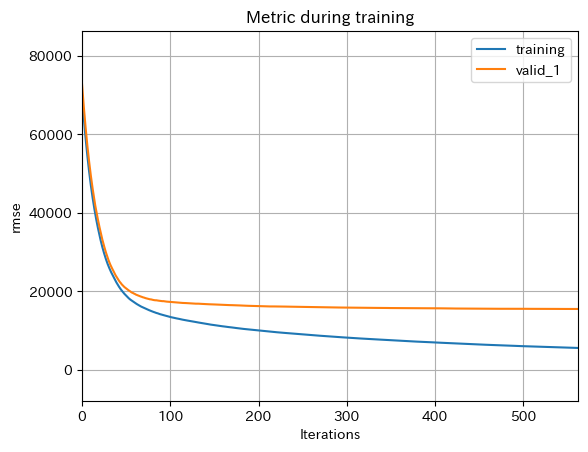

,importance
面積,4.558533e+14
L,3.946700e+14
平均地価,2.016189e+14
最寄り駅,9.690174e+13
築年数,7.051994e+13
所在地,3.562791e+13
全体の階数,3.062781e+13
一部屋あたりの面積,2.763642e+13
契約期間,1.320555e+13
所在階,1.277570e+13


In [4]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

## 「放送・通信」に関しては、全て突っ込んでもスコアが良くなる！

In [31]:
df_importance[40:]

,importance
室内洗濯機置場,1.559628e+11
敷地内ごみ置き場,1.217764e+11
下水,1.188030e+11
バルコニー,1.124084e+11
50m^2以上75m^2未満,1.082882e+11
公営水道,1.003075e+11
独立キッチン,9.752693e+10
フローリング,9.135702e+10
2面採光,8.582991e+10
ロフト,8.478210e+10
